<a href="https://colab.research.google.com/github/darktempler120/titanic/blob/master/Copy_of_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fancyimpute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

train_data = pd.read_csv("/content/train.csv")
test_data = pd.read_csv("/content/test.csv")

train = train_data.copy()
test = test_data.copy()

In [68]:
print(train.info())
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [69]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Let's first take a look rate of missing data for each predictors.

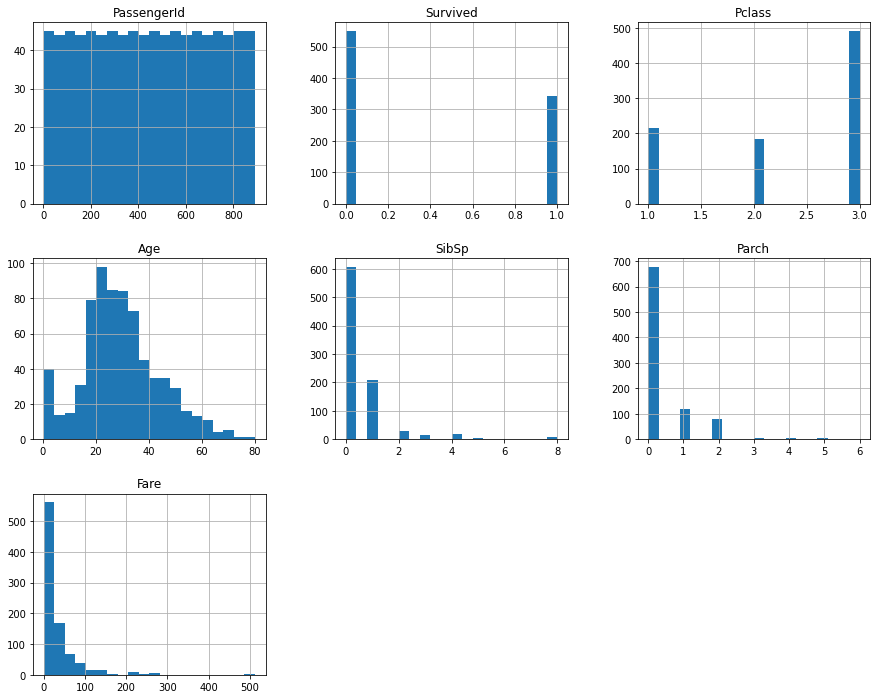

In [70]:
train.hist(figsize=(15,12), bins = 20)
plt.show()

Let's look at each variable's distribution to gain more insight of the data


In [71]:
missing = train.isnull().sum() / len(train_data)
missing[(missing != 0)]

Age         0.198653
Cabin       0.771044
Embarked    0.002245
dtype: float64

- Age is missing about 20% of its data.
- Cabin is missing about 77% of its data.
- Embarked is missing about 0.2% of its data.

We remove `cabin` since its missing majority of its data.

We also remove `PassengerID`, `Name`, `Ticket` since they are not relevant.

In [72]:
train.drop(columns = ['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)
test.drop(columns = ['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)

We will use multiple imputation to replace missing data.

In [73]:
train_imp = train.copy()
s = (train_imp.dtypes == 'object')
t = (train_imp.dtypes == 'category')
cols = s | t

train_imp = pd.get_dummies(train_imp, columns = train_imp.columns[cols], drop_first= True).copy()

mice_imputer = IterativeImputer()
result = mice_imputer.fit_transform(train_imp)

train_imp = pd.DataFrame(result, columns = train_imp.columns).copy()

train.Age = train_imp.Age.copy()

In [74]:
test_imp = test.copy()
s = (test_imp.dtypes == 'object')
t = (test_imp.dtypes == 'category')
cols = s | t

test_imp = pd.get_dummies(test_imp, columns = test_imp.columns[cols], drop_first= True).copy()

mice_imputer = IterativeImputer()
result = mice_imputer.fit_transform(test_imp)

test_imp = pd.DataFrame(result, columns = test_imp.columns).copy()

test.Age = test_imp.Age.copy()

In [75]:
cols

Pclass      False
Sex          True
Age         False
SibSp       False
Parch       False
Fare        False
Embarked     True
dtype: bool

In [76]:
ss= StandardScaler()
features= ['Age', 'SibSp', 'Fare']

trainX = train_imp.drop(columns = ['Survived_1'])
trainY = train.Survived

trainX[features] = ss.fit_transform(trainX[features])

logisticRegr = LogisticRegression()
logisticRegr.fit(trainX, trainY)

predictions = logisticRegr.predict(test_imp)

KeyError: ignored

In [ ]:
submission= pd.DataFrame({'PassengerId' : test_data['PassengerId'], 'Survived': predictions })

filename= 'titanic predictions.csv'
submission.to_csv(filename, index=False)